In [4]:
import torch
import wandb
import torch.optim as optim
from utils.wandb import wandb_init
from train_rq_vae import train
from omegaconf import OmegaConf
from plotting.plot import plot_results_panels
from data.loader import load_amazon
from modules.rq_vae import RQ_VAE
from utils.model_id_generation import generate_model_id

In [5]:
cfg = OmegaConf.load('config/config_amazon.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb_init(cfg)

data = load_amazon(
    category=cfg.data.category,
    normalize_data=cfg.data.normalize_data,
    train=True)

model = RQ_VAE(
        input_dim = data.shape[1],
        latent_dim = cfg.model.latent_dimension,
        hidden_dims = cfg.model.hidden_dimensions,
        codebook_size = cfg.model.codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = cfg.model.num_codebook_layers,
        commitment_weight = cfg.model.commitment_weight,
)
model.to(device)

wandb.watch(model)

optimizer = optim.AdamW(model.parameters(), lr=cfg.train.learning_rate, weight_decay=cfg.train.weight_decay)

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Prob Unique IDs,▁▁▂▂▂▃▄▅▆▇██████████████████████████████
RQ-VAE Loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▅▅▆▆▇▇▇▇▇▇██
Reconstruction Loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,255
Loss,196.11996
Prob Unique IDs,0.99427
RQ-VAE Loss,25.63672
Reconstruction Loss,170.48325


In [6]:
losses = train(model, data, optimizer, cfg.train.num_epochs, device, cfg)

if cfg.general.save_model:
    model_id = generate_model_id(cfg)
    print(f"Model ID: {model_id}")
    torch.save(model.state_dict(), f"models/{model_id}.pth")
    
#model.load_state_dict(torch.load("models/amazon-beauty-bs256-normF-hd768_512_256-ld256-cb3x256-cw0.25-lr0.001-wd0.0001-ep200.pth"))
wandb.finish()

Training Loop: 100%|██████████| 256/256 [03:36<00:00,  1.18it/s, Epoch=255, Loss=179, Reconstruction Loss=176, RQ-VAE Loss=3.5, Prob Unique IDs=0.997]    


Model ID: amazon-bs256-normF-hd768_512_256_128-ld128-cb3x256-cw0.25-lr0.0005-wd0.0001-ep256


Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇████
Loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Prob Unique IDs,▁▁▁▁▁▁▁▁▂▂▄▄▅▆▇▇▇███████████████████████
RQ-VAE Loss,▂▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇█
Reconstruction Loss,█▇▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,255
Loss,179.08443
Prob Unique IDs,0.9967
RQ-VAE Loss,3.50154
Reconstruction Loss,175.58289


In [7]:
model.get_semantic_ids(data.to(device)).sem_ids

tensor([[247, 216,  11],
        [147, 208, 221],
        [ 84,  53,  48],
        ...,
        [198, 179, 195],
        [ 92, 245, 129],
        [124, 223,   5]], device='cuda:0')

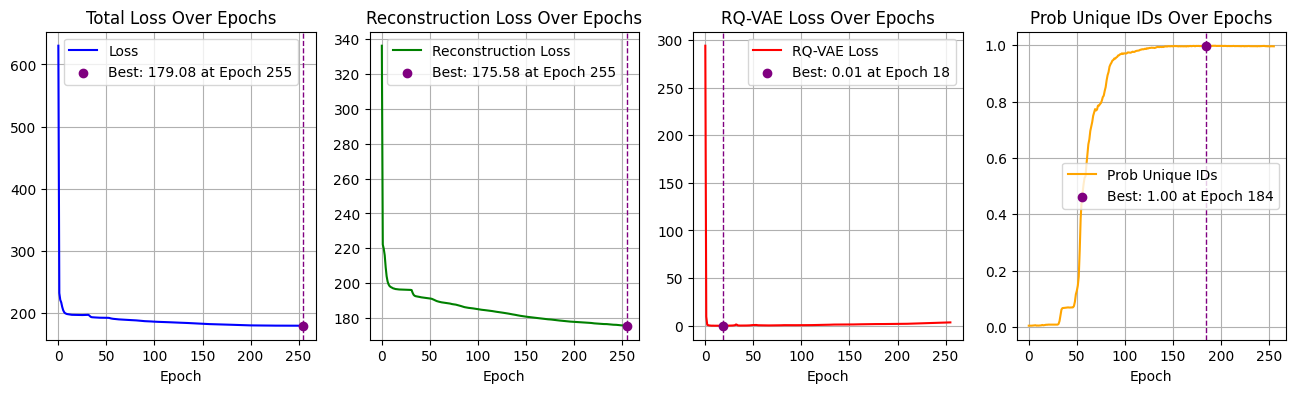

In [8]:
# Plot configuration
plot_configs = [
    ('Loss', 'Total Loss Over Epochs', 'blue', 'low'),
    ('Reconstruction Loss', 'Reconstruction Loss Over Epochs', 'green', 'low'),
    ("RQ-VAE Loss", 'RQ-VAE Loss Over Epochs', 'red', 'low'),
    ('Prob Unique IDs', 'Prob Unique IDs Over Epochs', 'orange', 'high'),
]

model_id = generate_model_id(cfg)
fig = plot_results_panels(losses, plot_configs)
fig.savefig(f"outputs/plots/{model_id}.png", dpi=600, bbox_inches='tight')